In [3]:
%matplotlib notebook
import imageio
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import gudhi
import matplotlib as mpl
import pickle
import sys
import time

sys.path.insert(0, '/Users/adeliegarin/Google Drive/PhD/Sinergia/Code/Topological-Image-Processing/Persistence Homology')

import filtrations as filt
import preprocessing as pre
import barcodes as bar
import plots as plot
import distances as dist
import pipeline as pipe

# First problem: 
#### can't compute score, persistence dim0 is an empty list []. This appen because there are no disconnected roads in the image, but need to be adressed anyhow. To fix this for now I artifically modify the image: label_s[1] = 0 

# problem solved : 
### Now it's accepted by the score

In [2]:
label = imageio.imread('manual_mods/gt.png')[:,:,0]>128
pred_mask = imageio.imread('manual_mods/one_dangling0.jpg')[:,:,0]>128

label_s = skeletonize(label*1)*1
pred_mask_s = skeletonize(pred_mask*1)*1

# this is a work around for now
#label_s[1] = 0 
#pred_mask_s[1] = 0

score = pipe.score_wasserstein_thickening_2D(pred_mask_s, label_s)

OSError: No such file: '/home/citraro/projects/topoloss4neurons/adelie_code/barcode_new_wasserstein/manual_mods/gt.png'

# Dangling roads: 
#### 1) the position affects the score.

For the thickening score, it's normal. This is still happening here

#### 2) A single dangling affects the score in the same way as many danglings

Not anymore

#### 3) a dangling road may not affect the score at all

same as 1)

In [4]:
label = imageio.imread('manual_mods/gt.png')[:,:,0]>128
pred_masks = [imageio.imread('manual_mods/one_dangling0.jpg')[:,:,0]>128,
              imageio.imread('manual_mods/one_dangling1.jpg')[:,:,0]>128,
              imageio.imread('manual_mods/one_dangling2.jpg')[:,:,0]>128,
              imageio.imread('manual_mods/many_dangling0.jpg')[:,:,0]>128]
names = ["One dangling 0", "One dangling 1", "One dangling 2" ,"Many danglings"]

label_s = skeletonize(label*1)*1

plt.figure(figsize=(10,5))
plt.subplot(1,1+len(pred_masks),1)
plt.imshow(label_s)
plt.title("Ground-truth")

for i,(pred_mask,name) in enumerate(zip(pred_masks, names)):
        
    pred_mask_s = skeletonize(pred_mask*1)*1

    score = pipe.score_wasserstein_thickening_2D(pred_mask_s, label_s)

    plt.subplot(1,1+len(pred_masks),i+2)
    plt.imshow(pred_mask_s)
    plt.title(name + "\n{:0.3f}----{:0.3f}".format(score[0],score[1]))

OSError: No such file: '/home/citraro/projects/topoloss4neurons/adelie_code/barcode_new_wasserstein/manual_mods/gt.png'

# Bridging roads:
#### 1) A dangling road may affect the score more than one (even many) bridges.

Now it seems to be more on the same scale, even though dangling roads could create bridges after only a few steps of dilatation, so it's normal that they have similar effect. The height score will be able to detect dangling roads much better. 

#### 2) the score change even with small variation of the position of the bridge (to see if it is a problem)

That's totally normal, as I explained to you last time

<IPython.core.display.Javascript object>


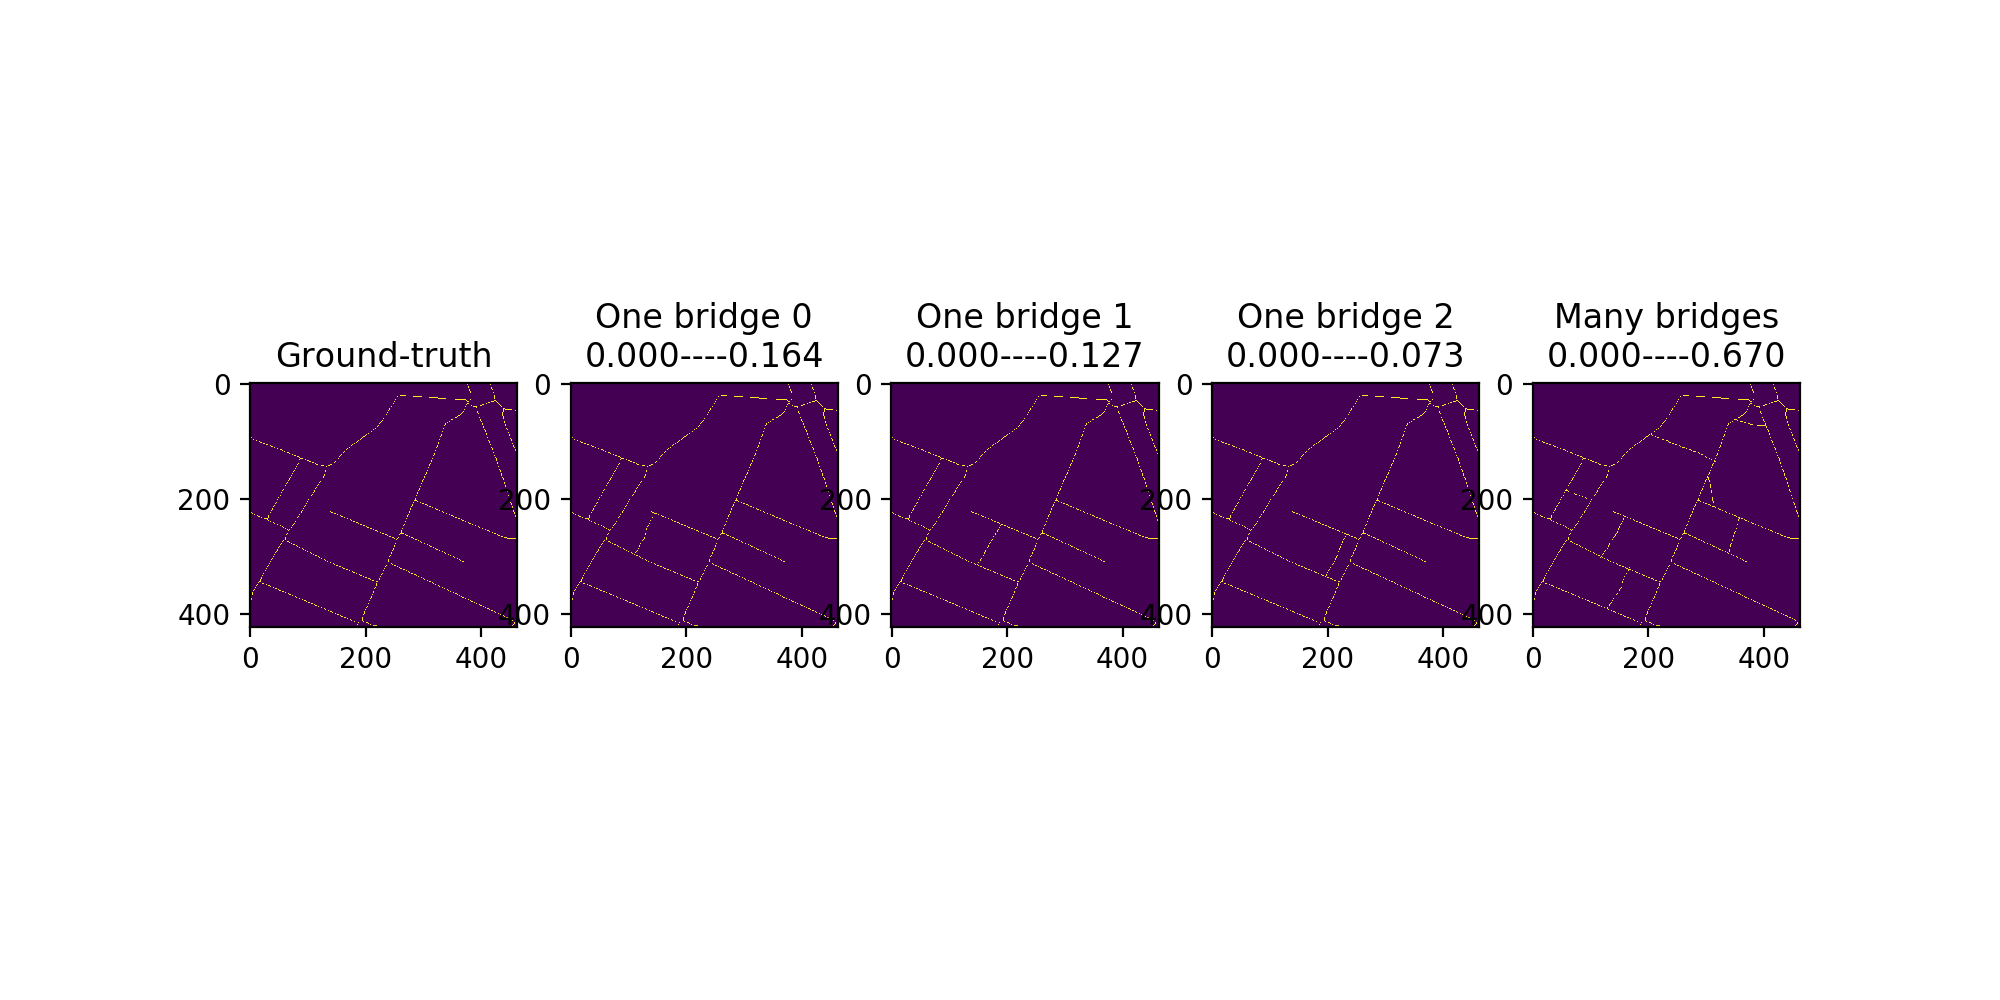

In [12]:
label = imageio.imread('manual_mods/gt.png')[:,:,0]>128
pred_masks = [imageio.imread('manual_mods/one_bridge0.jpg')[:,:,0]>128,
              imageio.imread('manual_mods/one_bridge1.jpg')[:,:,0]>128,
              imageio.imread('manual_mods/one_bridge2.jpg')[:,:,0]>128,
              imageio.imread('manual_mods/many_bridge0.jpg')[:,:,0]>128]
names = ["One bridge 0", "One bridge 1", "One bridge 2" ,"Many bridges"]

label_s = skeletonize(label*1)*1

plt.figure(figsize=(10,5))
plt.subplot(1,1+len(pred_masks),1)
plt.imshow(label_s)
plt.title("Ground-truth")

for i,(pred_mask,name) in enumerate(zip(pred_masks, names)):
        
    pred_mask_s = skeletonize(pred_mask*1)*1

    score = pipe.score_wasserstein_thickening_2D(pred_mask_s, label_s)

    plt.subplot(1,1+len(pred_masks),i+2)
    plt.imshow(pred_mask_s)
    plt.title(name + "\n{:0.3f}----{:0.3f}".format(score[0],score[1]))

# Interrupted roads:
#### 1) the position of the interruption affects a bit the score

Again, totally normal, but the height score might give better information on their positions. 

#### 2) the score is affected more by the danglings than by interruptions

Yes, the second value of the score. However, the first value is always 0 if there are no disconnections, but changes when there are some (according to their size). 

<IPython.core.display.Javascript object>


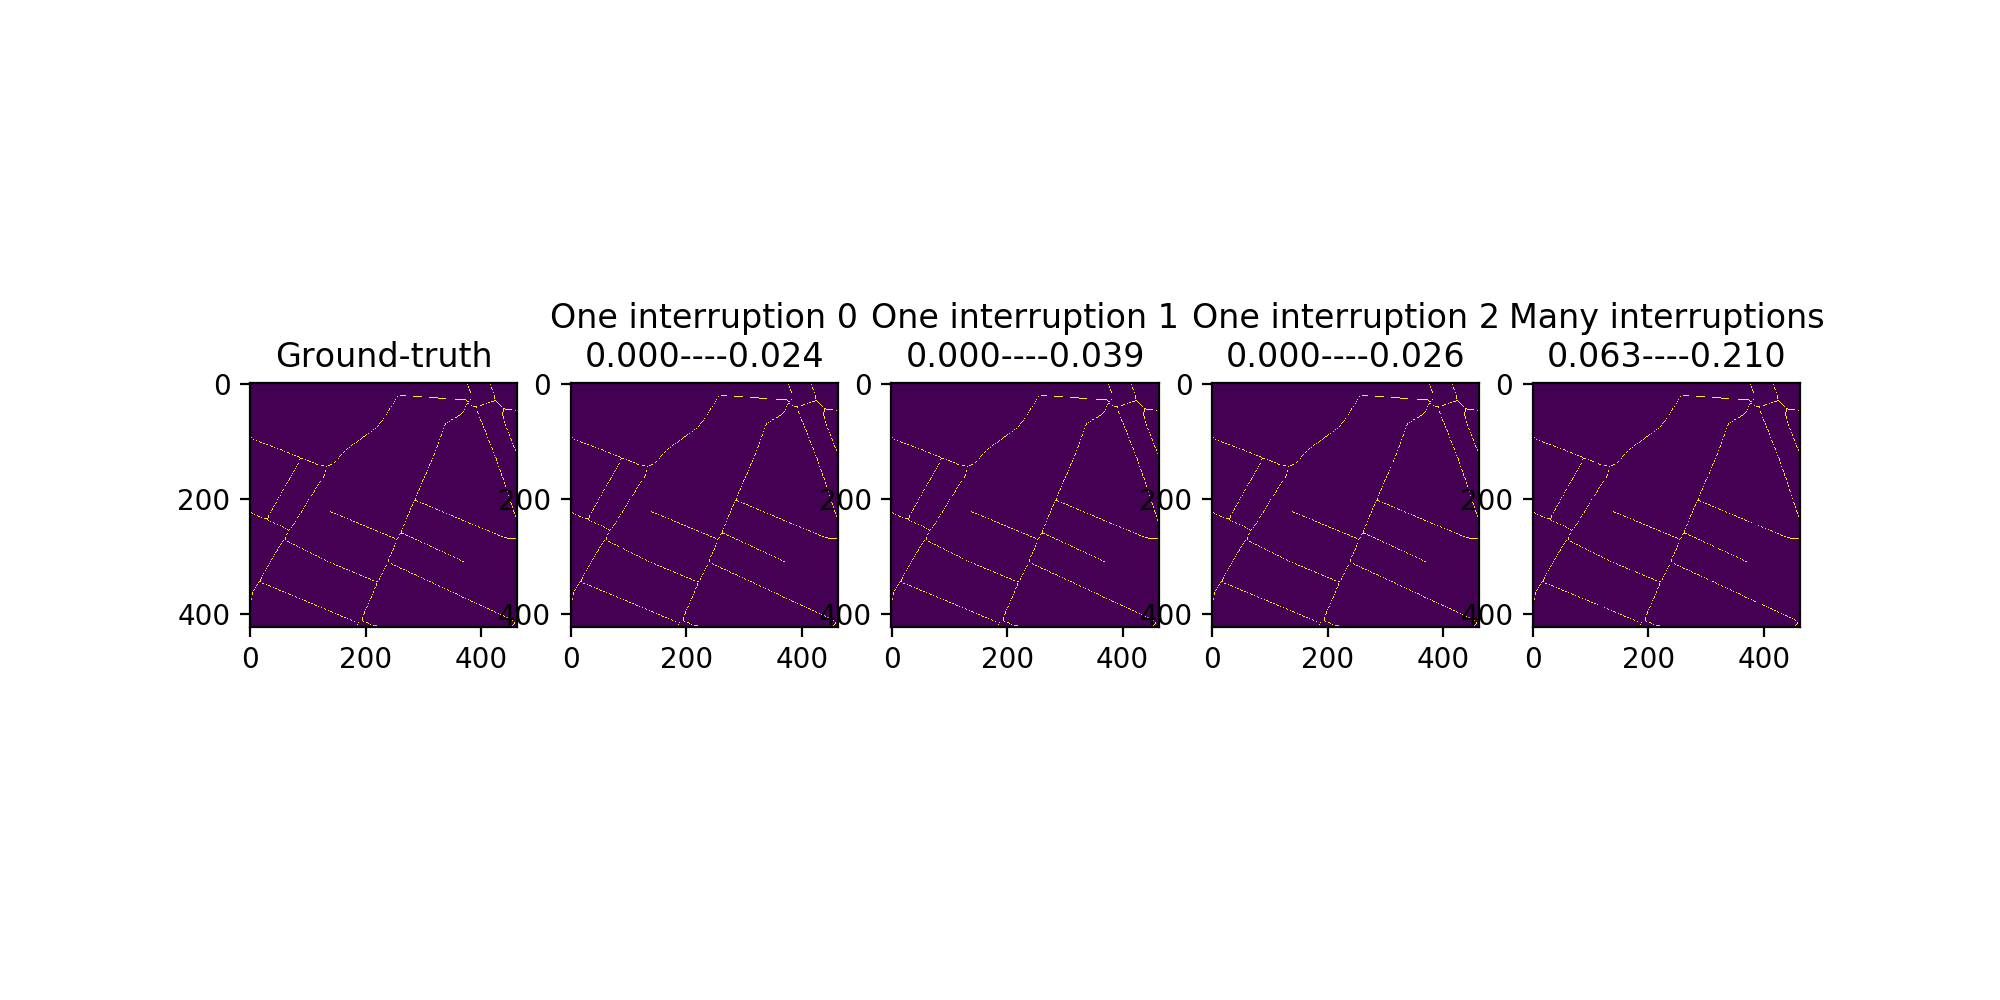

In [8]:
label = imageio.imread('manual_mods/gt.png')[:,:,0]>128
pred_masks = [imageio.imread('manual_mods/one_interruption0.jpg')[:,:,0]>128,
              imageio.imread('manual_mods/one_interruption1.jpg')[:,:,0]>128,
              imageio.imread('manual_mods/one_interruption3.jpg')[:,:,0]>128,
              imageio.imread('manual_mods/many_interruption0.jpg')[:,:,0]>128]
names = ["One interruption 0", "One interruption 1", "One interruption 2" ,"Many interruptions"]

label_s = skeletonize(label*1)*1

plt.figure(figsize=(10,5))
plt.subplot(1,1+len(pred_masks),1)
plt.imshow(label_s)
plt.title("Ground-truth")


for i,(pred_mask,name) in enumerate(zip(pred_masks, names)):
        
    pred_mask_s = skeletonize(pred_mask*1)*1

    score = pipe.score_wasserstein_thickening_2D(pred_mask_s, label_s)

    plt.subplot(1,1+len(pred_masks),i+2)
    plt.imshow(pred_mask_s)
    plt.title(name + "\n{:0.3f}----{:0.3f}".format(score[0],score[1]))

# Score is translation invariant
#### Score is 0 even if the prediction is very far from the ground-truth

The height score will change, but it's normal

<IPython.core.display.Javascript object>


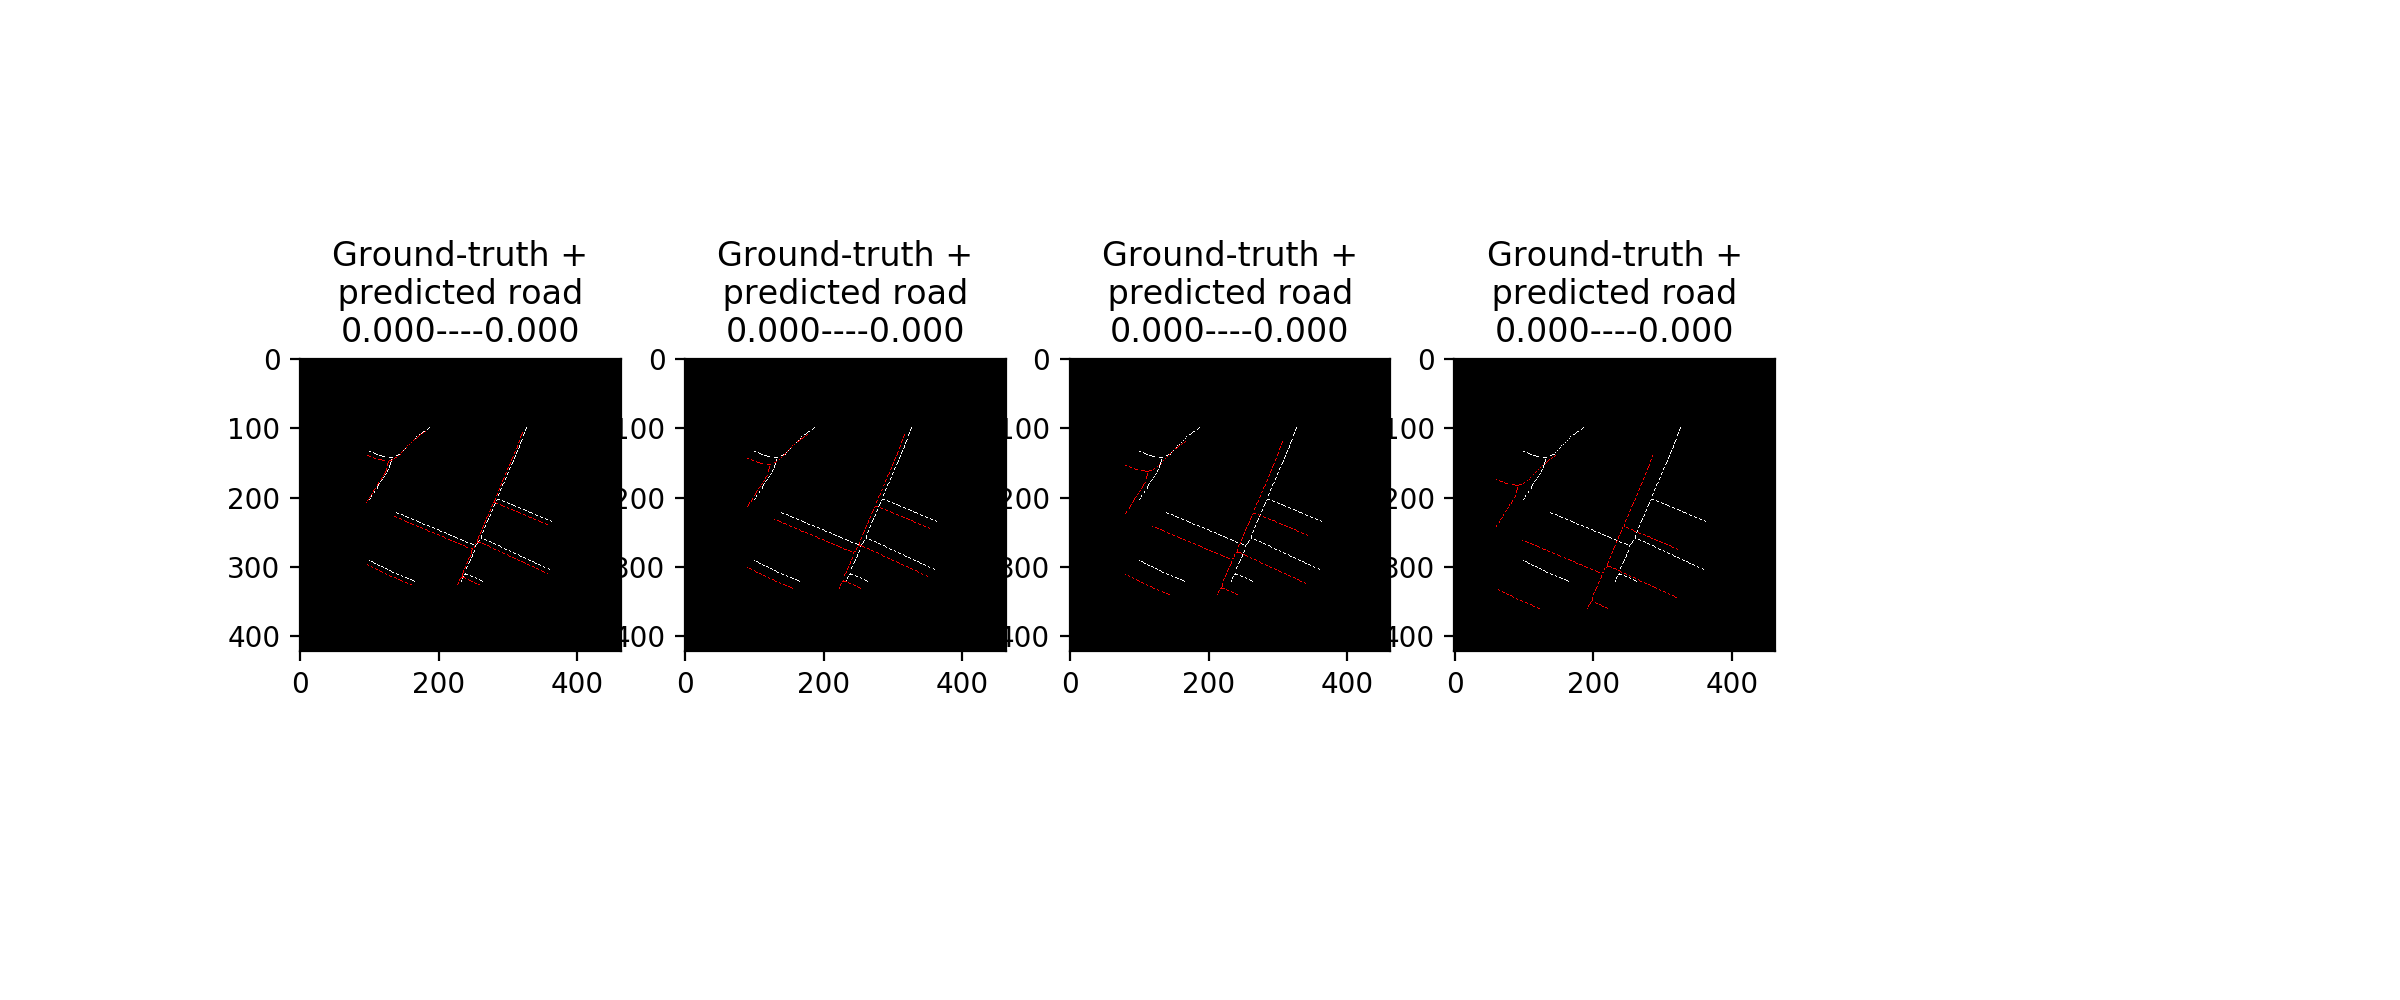

In [17]:
label = imageio.imread('manual_mods/gt.png')[:,:,0]>128
label[:100] = 0
label[-100:] = 0
label[:,:100] = 0
label[:,-100:] = 0

shifts = [5, 10, 20, 40]

plt.figure(figsize=(12,5))
for i,shift in enumerate(shifts):
    pred_mask = label.copy()
    pred_mask[shift:] = pred_mask[:-shift]
    pred_mask[:,:-shift] = pred_mask[:,shift:]

    label_s = skeletonize(label*1)*1
    pred_mask_s = skeletonize(pred_mask*1)*1

    _comb = np.stack([label_s.copy()]*3, 2)
    _comb[pred_mask_s>0] = np.array([1,0,0])

    score = pipe.score_wasserstein_thickening_2D(pred_mask_s, label_s)

    plt.subplot(1,len(scales),i+1)
    plt.imshow(_comb*255)
    plt.title("Ground-truth +\n predicted road \n{:0.3f}----{:0.3f}".format(score[0], score[1]))

# Rotation invariance
#### The score is not really rotation invariant but it does not reflect the topological error. In the example here bellow we rotate the prediction by 180° and the score is lower than a having one dangling road.

Now, the score increases up to 90 then decreases at 180. Which makes sense with the fact that the rotation changes the topology of the image, as the distance to the boundary of the image changes, but it becomes more similar at 90 or 180 than for non right angles. (don't know if that makes sense, but anyway we're not that interested in the rotation right?)

<IPython.core.display.Javascript object>


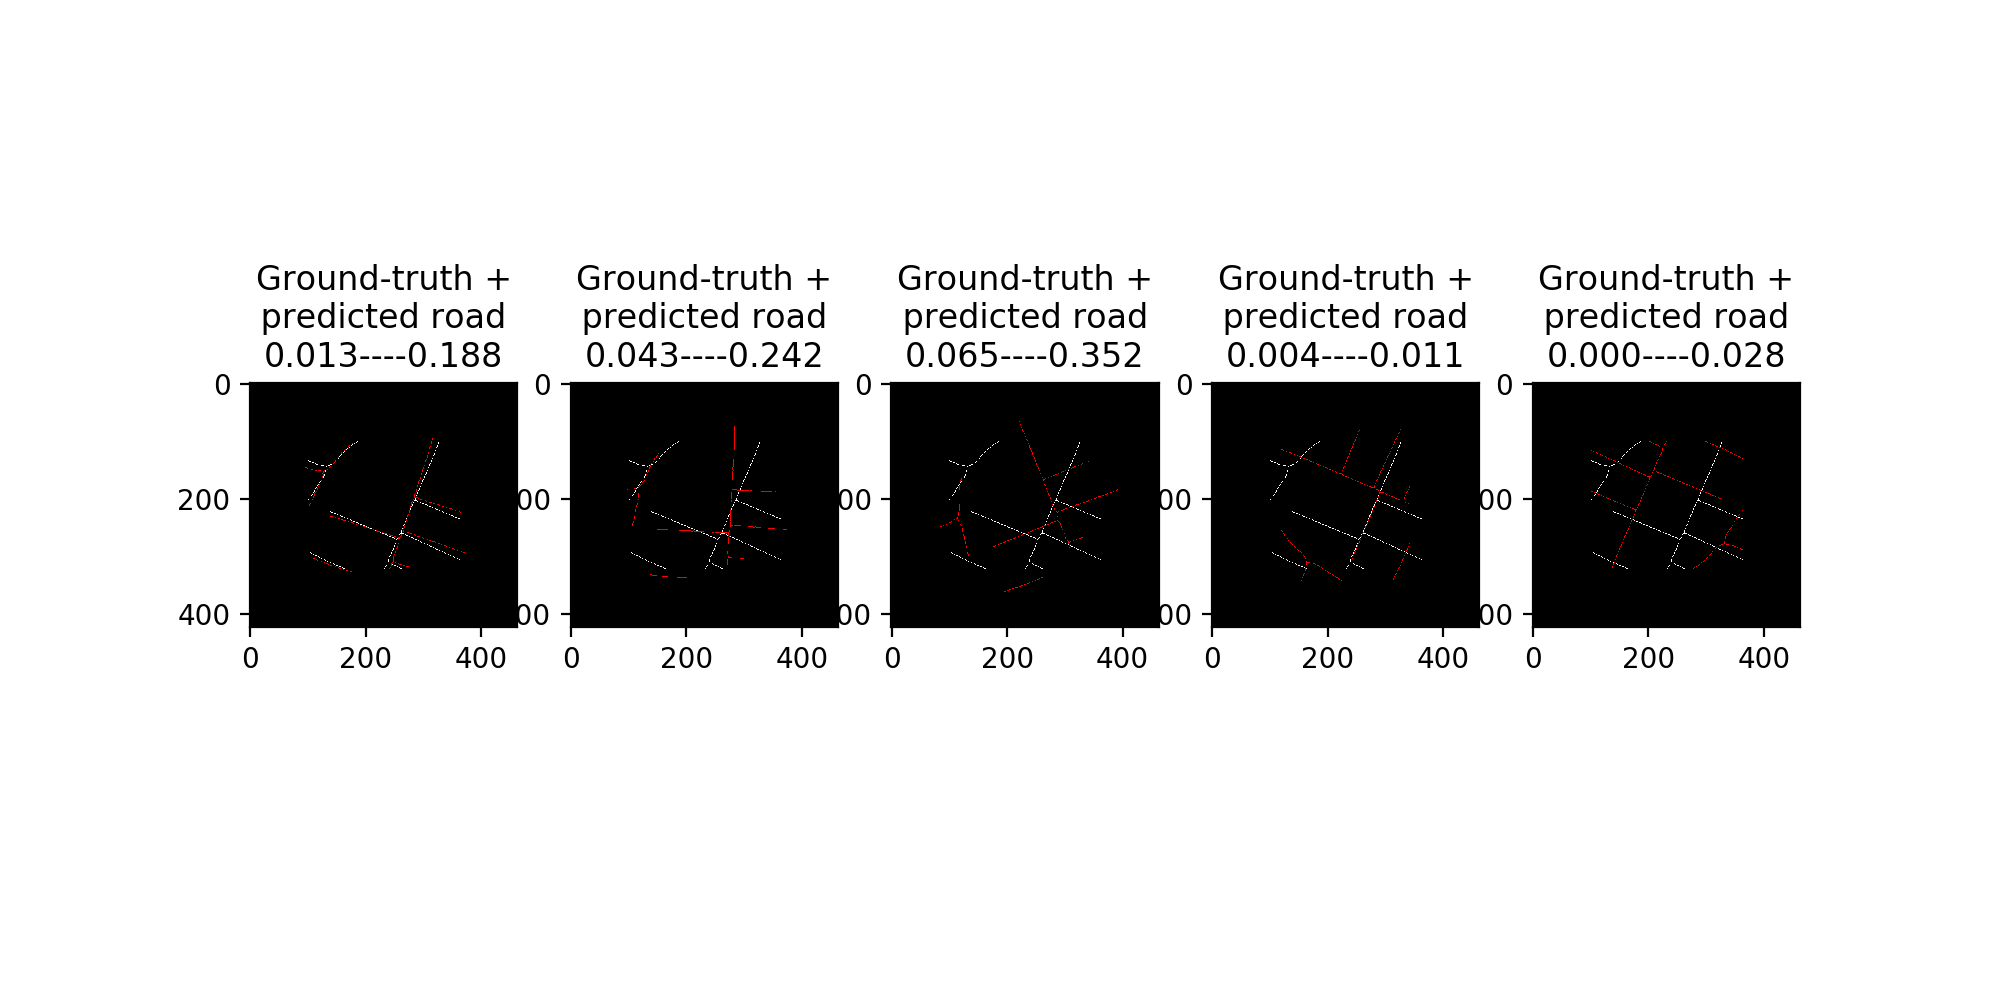

In [18]:
from skimage.transform import rotate

label = imageio.imread('manual_mods/gt.png')[:,:,0]>128
label[:100] = 0
label[-100:] = 0
label[:,:100] = 0
label[:,-100:] = 0

angles = [5, 20, 45, 90, 180]

plt.figure(figsize=(10,5))
for i,angle in enumerate(angles):
    pred_mask = label.copy()
    pred_mask = (rotate(pred_mask, angle)>0)

    label_s = skeletonize(label*1)*1
    pred_mask_s = skeletonize(pred_mask*1)*1

    _comb = np.stack([label_s.copy()]*3, 2)
    _comb[pred_mask_s>0] = np.array([1,0,0])

    score = pipe.score_wasserstein_thickening_2D(pred_mask_s, label_s)

    plt.subplot(1,len(angles),i+1)
    plt.imshow(_comb*255)
    plt.title("Ground-truth +\n predicted road \n{:0.3f}----{:0.3f}".format(score[0], score[1]))

# Rescaling the prediction
#### The score seems to change according to the error in the image, however, in the first image here below the score is equal as having a bridge. The first image here below should givea result closer to 0, instead gives the same error as a bridge. 

Now it's smaller than bridges. However, it's normal that the score changes by rescaling, as technically you could be creating bridges or disconnections by making some parts of the road "disappear". But again, rescaling is not too much of a problem in your algorithms for reconstruction, right?

<IPython.core.display.Javascript object>


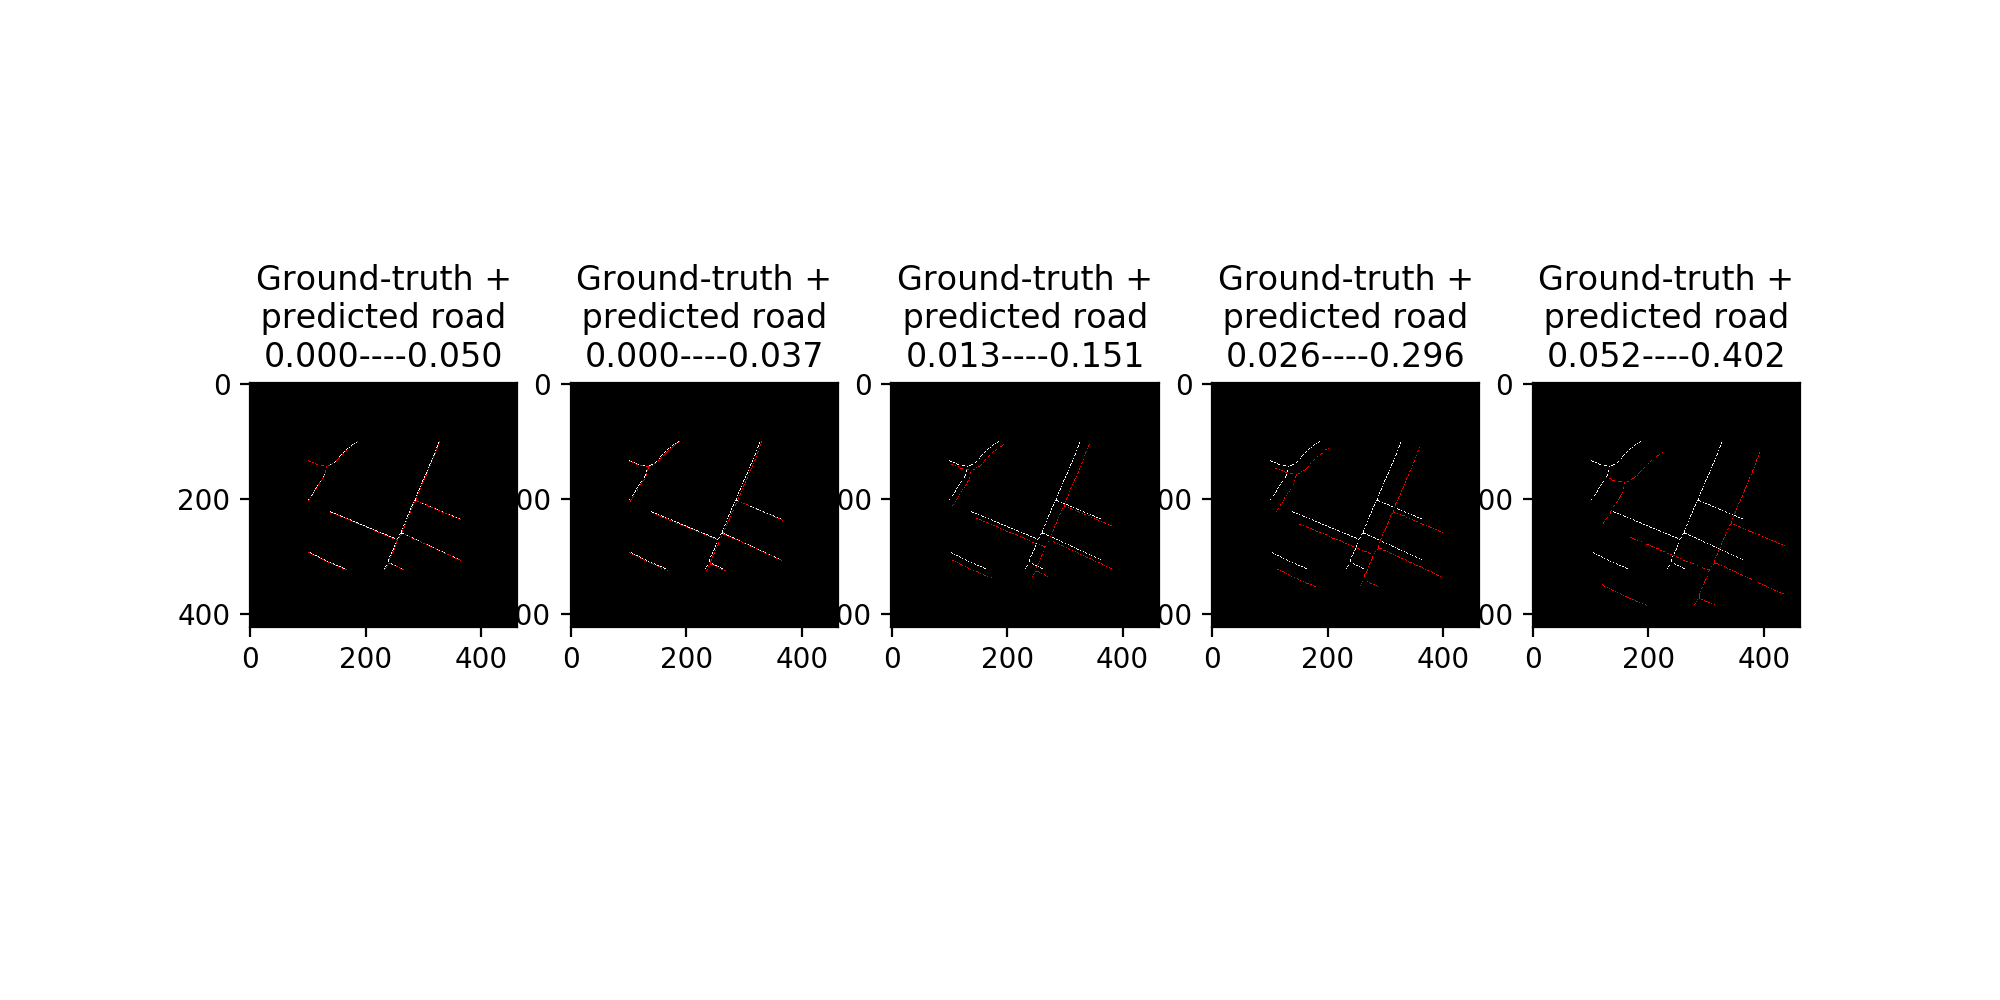

In [11]:
from skimage.transform import rescale

label = imageio.imread('manual_mods/gt.png')[:,:,0]>128
label[:100] = 0
label[-100:] = 0
label[:,:100] = 0
label[:,-100:] = 0

scales = [1.005, 1.01, 1.05, 1.1, 1.2]

plt.figure(figsize=(10,5))
for i,scale in enumerate(scales):
    pred_mask = label.copy()
    pred_mask = (rescale(pred_mask, scale, multichannel=False, 
                         anti_aliasing=True, mode='constant')>0)
    pred_mask = pred_mask[:label.shape[0], :label.shape[1]]

    label_s = skeletonize(label*1)*1
    pred_mask_s = skeletonize(pred_mask*1)*1

    _comb = np.stack([label_s.copy()]*3, 2)
    _comb[pred_mask_s>0] = np.array([1,0,0])

    score = pipe.score_wasserstein_thickening_2D(pred_mask_s, label_s)

    plt.subplot(1,len(scales),i+1)
    plt.imshow(_comb*255)
    plt.title("Ground-truth +\n predicted road \n{:0.3f}----{:0.3f}".format(score[0], score[1]))